<a href="https://colab.research.google.com/github/thegit-69/star-summit/blob/main/vinodh_spss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Preprocessing data...
Running 10 iterations for each algorithm...
Iteration 1/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 2/10
  Training SVM...
  Training ANN...


  Training Autoencoder...
Iteration 3/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 4/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 5/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 6/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 7/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 8/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 9/10
  Training SVM...
  Training ANN...
  Training Autoencoder...
Iteration 10/10
  Training SVM...
  Training ANN...
  Training Autoencoder...

Accuracy Results (%):
+--------------+--------+--------+---------------+
|              | SVM    | ANN    | Autoencoder   |
+==============+========+========+===============+
| Iteration 1  | 45.83% | 37.50% | 33.33%        |
+--------------+--------+--------+---------------+
| Iteration 2  | 45.83% | 35.42% | 33.33%        |
+--------------+--------+---

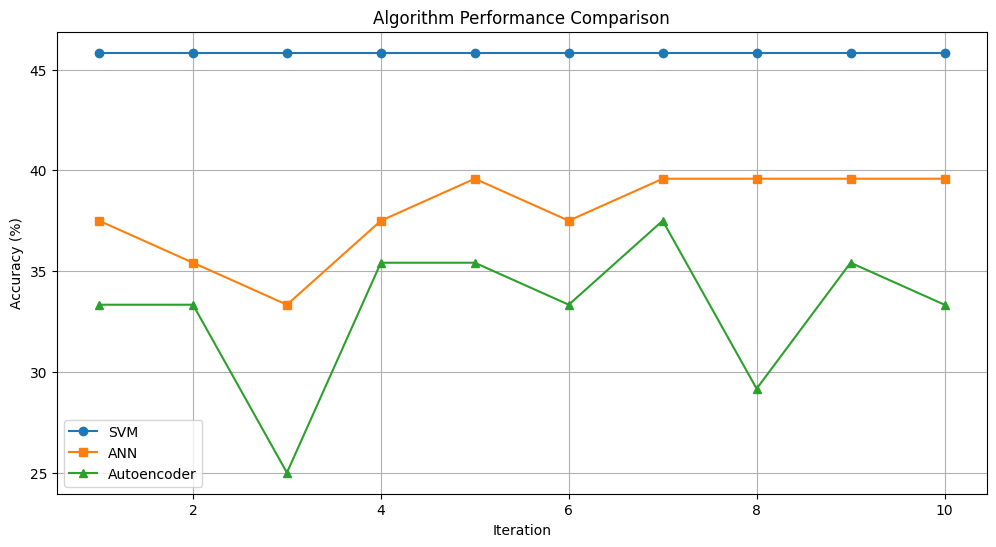


Class Distribution:
Corn_Cercospora_Leaf_Spot: 31 samples
Tomato_Fusarium: 17 samples
Tomato_Late_Blight: 14 samples
Corn_Streak: 12 samples
Tomato_Septoria: 12 samples
Pepper_Septoria: 10 samples
Pepper_Late_Blight: 9 samples
Pepper_Bacterial_Spot: 9 samples
Pepper_Leaf_Mosaic: 8 samples
Pepper_Fusarium: 7 samples
Corn_Healthy: 6 samples
Tomato_Early_Blight: 5 samples
Corn_Common_Rust: 5 samples
Tomato_Healthy: 4 samples
Pepper_Cercospora: 4 samples
Pepper_Leaf_Curl: 3 samples
Pepper_Healthy: 3 samples

Best Model Performance:
SVM achieved the highest accuracy: 45.83%


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
print("Loading dataset...")
df = pd.read_csv("/content/new ds.csv")

# Data preprocessing
print("Preprocessing data...")
# Extract features from bounding box coordinates
df['box_width'] = df['xmax'] - df['xmin']
df['box_height'] = df['ymax'] - df['ymin']
df['box_area'] = df['box_width'] * df['box_height']
df['box_ratio'] = df['box_width'] / df['box_height']
df['box_center_x'] = (df['xmax'] + df['xmin']) / 2
df['box_center_y'] = (df['ymax'] + df['ymin']) / 2

# Create feature matrix
X = df[['confidence', 'box_width', 'box_height', 'box_area', 'box_ratio', 'box_center_x', 'box_center_y']]

# Extract the class labels
y = df['class']

# Encode the class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))

# Create one-hot encoded labels for neural networks
y_onehot = to_categorical(y_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
_, _, y_train_onehot, y_test_onehot = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Results storage
results = {
    'SVM': [],
    'ANN': [],
    'Autoencoder': []
}

# Function to build ANN model
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to build Autoencoder model
def create_autoencoder_model(input_shape, num_classes, encoding_dim=16):
    # Encoder
    input_layer = Input(shape=(input_shape,))
    encoder = Dense(64, activation='relu')(input_layer)
    encoder = Dense(32, activation='relu')(encoder)
    encoded = Dense(encoding_dim, activation='relu')(encoder)

    # Decoder for reconstruction
    decoder = Dense(32, activation='relu')(encoded)
    decoder = Dense(64, activation='relu')(decoder)
    decoder = Dense(input_shape, activation='sigmoid')(decoder)

    # Classifier
    classifier = Dense(64, activation='relu')(encoded)
    classifier = Dense(32, activation='relu')(classifier)
    classifier = Dense(num_classes, activation='softmax')(classifier)

    # Create models
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    classifier_model = Model(inputs=input_layer, outputs=classifier)

    # Compile models
    autoencoder.compile(optimizer='adam', loss='mse')
    classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return autoencoder, classifier_model

# Run 10 iterations for each algorithm
print("Running 10 iterations for each algorithm...")
for i in range(10):
    print(f"Iteration {i+1}/10")

    # SVM
    print("  Training SVM...")
    svm_clf = SVC(kernel='rbf', C=10.0, gamma='scale', random_state=i)
    svm_clf.fit(X_train_scaled, y_train)
    y_pred_svm = svm_clf.predict(X_test_scaled)
    accuracy_svm = accuracy_score(y_test, y_pred_svm) * 100
    results['SVM'].append(accuracy_svm)

    # ANN
    print("  Training ANN...")
    ann_model = create_ann_model(X_train_scaled.shape[1], num_classes)
    ann_model.fit(
        X_train_scaled, y_train_onehot,
        epochs=50,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )
    y_pred_proba_ann = ann_model.predict(X_test_scaled, verbose=0)
    y_pred_ann = np.argmax(y_pred_proba_ann, axis=1)
    accuracy_ann = accuracy_score(y_test, y_pred_ann) * 100
    results['ANN'].append(accuracy_ann)

    # Autoencoder
    print("  Training Autoencoder...")
    autoencoder, classifier = create_autoencoder_model(X_train_scaled.shape[1], num_classes)

    # First train the autoencoder
    autoencoder.fit(
        X_train_scaled, X_train_scaled,
        epochs=30,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )

    # Then train the classifier
    classifier.fit(
        X_train_scaled, y_train_onehot,
        epochs=50,
        batch_size=32,
        verbose=0,
        validation_split=0.2
    )

    y_pred_proba_ae = classifier.predict(X_test_scaled, verbose=0)
    y_pred_ae = np.argmax(y_pred_proba_ae, axis=1)
    accuracy_ae = accuracy_score(y_test, y_pred_ae) * 100
    results['Autoencoder'].append(accuracy_ae)

# Display results in a table
print("\nAccuracy Results (%):")
table_data = []
for i in range(10):
    table_data.append([
        f"Iteration {i+1}",
        f"{results['SVM'][i]:.2f}%",
        f"{results['ANN'][i]:.2f}%",
        f"{results['Autoencoder'][i]:.2f}%"
    ])

headers = ["", "SVM", "ANN", "Autoencoder"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Calculate statistics
print("\nSummary Statistics:")
stats_data = [
    ["Mean", f"{np.mean(results['SVM']):.2f}%", f"{np.mean(results['ANN']):.2f}%", f"{np.mean(results['Autoencoder']):.2f}%"],
    ["Max", f"{np.max(results['SVM']):.2f}%", f"{np.max(results['ANN']):.2f}%", f"{np.max(results['Autoencoder']):.2f}%"],
    ["Min", f"{np.min(results['SVM']):.2f}%", f"{np.min(results['ANN']):.2f}%", f"{np.min(results['Autoencoder']):.2f}%"],
    ["Std Dev", f"{np.std(results['SVM']):.2f}%", f"{np.std(results['ANN']):.2f}%", f"{np.std(results['Autoencoder']):.2f}%"]
]
print(tabulate(stats_data, headers=headers, tablefmt="grid"))

# Visualize the results
plt.figure(figsize=(12, 6))
iterations = list(range(1, 11))
plt.plot(iterations, results['SVM'], 'o-', label='SVM')
plt.plot(iterations, results['ANN'], 's-', label='ANN')
plt.plot(iterations, results['Autoencoder'], '^-', label='Autoencoder')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Algorithm Performance Comparison')
plt.legend()
plt.grid(True)
plt.savefig('algorithm_comparison.png')
plt.show()

# Print class distribution
print("\nClass Distribution:")
class_counts = df['class'].value_counts()
for cls, count in class_counts.items():
    print(f"{cls}: {count} samples")

# Print model with highest accuracy
best_svm = np.max(results['SVM'])
best_ann = np.max(results['ANN'])
best_ae = np.max(results['Autoencoder'])
best_overall = max(best_svm, best_ann, best_ae)

print("\nBest Model Performance:")
if best_overall == best_svm:
    print(f"SVM achieved the highest accuracy: {best_svm:.2f}%")
elif best_overall == best_ann:
    print(f"ANN achieved the highest accuracy: {best_ann:.2f}%")
else:
    print(f"Autoencoder achieved the highest accuracy: {best_ae:.2f}%")